# TUMBLR ANALYSIS

## Preparations

### Load the modules

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

!pip install torchviz
from torchviz import make_dot
!pip install graphviz
from sklearn.tree import export_graphviz
import graphviz

In [15]:
# prompt: load google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the data

In [16]:
label = pd.read_csv('/content/drive/My Drive/LAOPO/user_for_label - Sheet1.csv')
sample = pd.read_csv('/content/drive/My Drive/LAOPO/sample_posts_labelled.csv')

### Data Preprocessing

Rename column name for merge.

In [17]:
sample = sample.rename(columns={"blog_name":"user_name"})
sample["note_count"] = pd.to_numeric(sample["note_count"], "coerce")

Check if user posted photos or videos

In [18]:
sample['type'] = sample['type'].map(lambda x: 1 if x in ['photo', 'video'] else 0)

Use Group by to get the feature for user.

In [19]:
type_ = sample.groupby('user_name')['type'].sum().reset_index()
total_note = sample.groupby('user_name')['note_count'].sum().reset_index()
total_likes = sample.groupby('user_name')['total_likes'].sum().reset_index()
total_reblogs = sample.groupby('user_name')['total_reblogs'].sum().reset_index()

Merge Groupby Results

In [20]:
user_feature = pd.merge(type_, total_note, on='user_name')
user_feature = pd.merge(user_feature, total_likes, on='user_name')
user_feature = pd.merge(user_feature, total_reblogs, on='user_name')
user_feature["type"] = user_feature["type"].map(lambda x: 1 if x >0 else 0)

In [21]:
label = label[['user_name', 'total_posts', 'description', 'allow_question', 'allow_question_anon', 'fake']]
label['description'] = label['description'].astype(str).apply(lambda x: len(x.split()))
label["total_posts"] = pd.to_numeric(label["total_posts"], "coerce")
label['allow_question'] = label['allow_question'].map(lambda x: 1 if x else 0)
label['allow_question_anon'] = label['allow_question_anon'].map(lambda x: 1 if x else 0)

In [22]:
final_data = pd.merge(label, user_feature, on='user_name', how='inner')
final_data

,user_name,total_posts,description,allow_question,allow_question_anon,fake,type,note_count,total_likes,total_reblogs
0,c,6,1,0,0,1,1,1761.0,1180.0,581.0
1,d,6,11,1,1,0,1,6887.0,3967.0,2920.0
2,javarisx-fightingthosedemons,20585,20,1,1,0,0,23228.0,14505.0,11767.0
3,thatsthat24,79796,18,1,0,0,1,32147.0,24300.0,7847.0
4,tyleroakley,48476,6,0,0,0,1,1743696.0,887565.0,856131.0
...,...,...,...,...,...,...,...,...,...,...
250,xomrsalliej4787xo,46362,16,1,0,0,0,12782.0,8968.0,3814.0
251,ghost-,9149,29,1,1,0,1,1009710.0,561084.0,448626.0
252,twiginthewind-7,108,1,0,0,1,0,1581.0,1354.0,227.0
253,omorfiprasinomatamou,18737,26,0,0,0,1,41469.0,27686.0,13783.0


Data normalization

In [23]:
final_data['total_posts'] = (final_data['total_posts'] - final_data['total_posts'].min())/(final_data['total_posts'].max() - final_data['total_posts'].min())
final_data['description'] = (final_data['description'] - final_data['description'].min())/(final_data['description'].max() - final_data['description'].min())
final_data['note_count'] = (final_data['note_count'] - final_data['note_count'].min())/(final_data['note_count'].max() - final_data['note_count'].min())
final_data['total_likes'] = (final_data['total_likes'] - final_data['total_likes'].min())/(final_data['total_likes'].max() - final_data['total_likes'].min())
final_data['total_reblogs'] = (final_data['total_reblogs'] - final_data['total_reblogs'].min())/(final_data['total_reblogs'].max() - final_data['total_reblogs'].min())

In [24]:
final_data

,user_name,total_posts,description,allow_question,allow_question_anon,fake,type,note_count,total_likes,total_reblogs
0,c,0.000014,0.000000,0,0,1,1,0.000079,0.000203,0.000036
1,d,0.000014,0.053476,1,1,0,1,0.000311,0.000681,0.000179
2,javarisx-fightingthosedemons,0.059192,0.101604,1,1,0,0,0.001049,0.002492,0.000721
3,thatsthat24,0.229462,0.090909,1,0,0,1,0.001452,0.004175,0.000481
4,tyleroakley,0.139397,0.026738,0,0,0,1,0.078754,0.152496,0.052457
...,...,...,...,...,...,...,...,...,...,...
250,xomrsalliej4787xo,0.133318,0.080214,1,0,0,0,0.000577,0.001541,0.000234
251,ghost-,0.026306,0.149733,1,1,0,1,0.045604,0.096402,0.027488
252,twiginthewind-7,0.000308,0.000000,0,0,1,0,0.000071,0.000232,0.000014
253,omorfiprasinomatamou,0.053878,0.133690,0,0,0,1,0.001873,0.004757,0.000845


In [25]:
final_data.drop(['user_name'], axis=1, inplace=True)

### Train Test Split

In [26]:
X = final_data.drop('fake', axis=1)
y = final_data['fake']

# Create an oversampler object
ros = RandomOverSampler(random_state=615)

# Resample the dataset
X_resampled, y_resampled = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=615, shuffle=True)

In [27]:
X_train_tensor = torch.FloatTensor(X_train.to_numpy())
y_train_tensor = torch.LongTensor(y_train.to_numpy())
X_test_tensor = torch.FloatTensor(X_test.to_numpy())
y_test_tensor = torch.LongTensor(y_test.to_numpy())

Data Loader

In [28]:
# DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
val_data = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(dataset=val_data, batch_size=64, shuffle=False)

## Baseline Modle Building

### ANN

In [29]:
# ANN Model
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)  # Adjust the input layer size
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # Adjust the output layer size based on the number of classes

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [30]:
model = ANN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
# Training with loss tracking for both training and validation
epochs = 50
train_losses = []
val_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            output = model(X_batch)
            loss = criterion(output, y_batch)
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_loader))
    print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}')

Epoch 1/50, Training Loss: 0.6797792414824168, Validation Loss: 0.6716486513614655
Epoch 2/50, Training Loss: 0.6484062771002451, Validation Loss: 0.6541137099266052
Epoch 3/50, Training Loss: 0.6169180572032928, Validation Loss: 0.6365666091442108
Epoch 4/50, Training Loss: 0.5858569542566935, Validation Loss: 0.6214612126350403
Epoch 5/50, Training Loss: 0.5546490848064423, Validation Loss: 0.6108148992061615
Epoch 6/50, Training Loss: 0.5405427664518356, Validation Loss: 0.607630729675293
Epoch 7/50, Training Loss: 0.5011010567347208, Validation Loss: 0.6096048951148987
Epoch 8/50, Training Loss: 0.4856744706630707, Validation Loss: 0.6136795878410339
Epoch 9/50, Training Loss: 0.4772339214881261, Validation Loss: 0.6171917617321014
Epoch 10/50, Training Loss: 0.47771989305814105, Validation Loss: 0.620926707983017
Epoch 11/50, Training Loss: 0.47001325090726215, Validation Loss: 0.6220348477363586
Epoch 12/50, Training Loss: 0.47778765857219696, Validation Loss: 0.6232200264930725


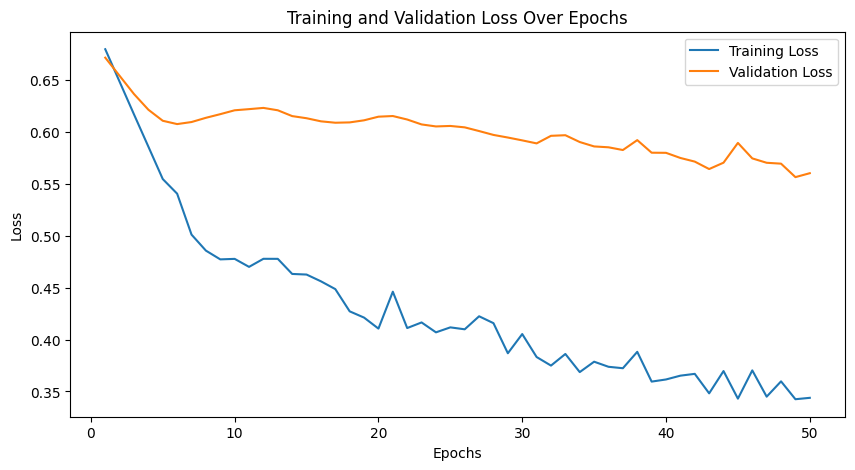

In [32]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [33]:
def get_predictions(model, X_tensor):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(X_tensor)
        _, predicted = torch.max(outputs.data, 1)
    return predicted



# Function to plot confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(title)

In [34]:
# Get predictions
y_pred_train = get_predictions(model, X_train_tensor)
y_pred_test = get_predictions(model, X_test_tensor)

# Generate confusion matrices
cm_train = confusion_matrix(y_train_tensor.numpy(), y_pred_train.numpy())
cm_test = confusion_matrix(y_test_tensor.numpy(), y_pred_test.numpy())

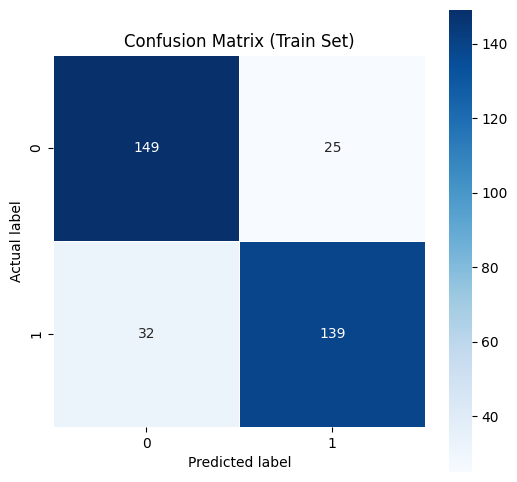

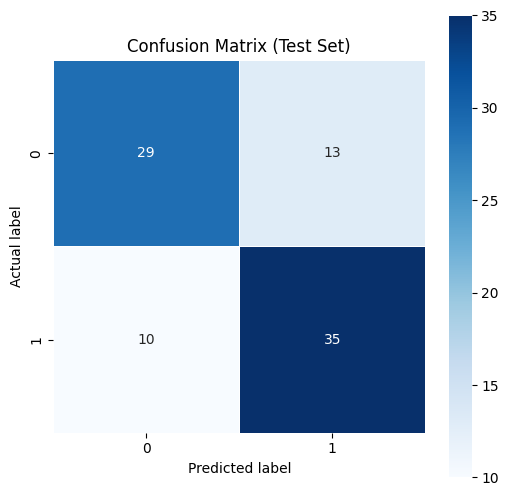

In [35]:
# Plot confusion matrices
plot_confusion_matrix(cm_train, 'Confusion Matrix (Train Set)')
plot_confusion_matrix(cm_test, 'Confusion Matrix (Test Set)')
plt.show()

In [36]:
# Get predictions for the test set
y_pred_test = get_predictions(model, X_test_tensor)

# Generate the classification report
report = classification_report(y_test_tensor.numpy(), y_pred_test.numpy())
print(report)

              precision    recall  f1-score   support

           0       0.74      0.69      0.72        42
           1       0.73      0.78      0.75        45

    accuracy                           0.74        87
   macro avg       0.74      0.73      0.73        87
weighted avg       0.74      0.74      0.74        87



Model Plot

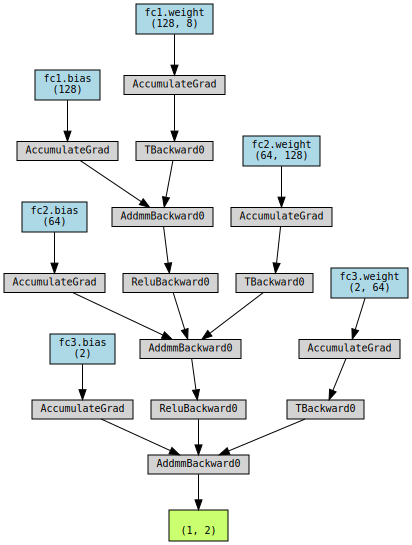

In [37]:
dummy_input = torch.randn(1, 8)

# Forward pass through the model
out = model(dummy_input)

# Create the visualization
dot = make_dot(out, params=dict(list(model.named_parameters()) + [('input', dummy_input)]))

# Display the visualization
dot.render('model_structure', format='png')  # This saves the plot as a PNG file
dot  # This line is for Jupyter Notebooks to display the plot inline

## Random Forest

In [38]:
# Create a Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

In [39]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94        42
           1       0.90      1.00      0.95        45

    accuracy                           0.94        87
   macro avg       0.95      0.94      0.94        87
weighted avg       0.95      0.94      0.94        87



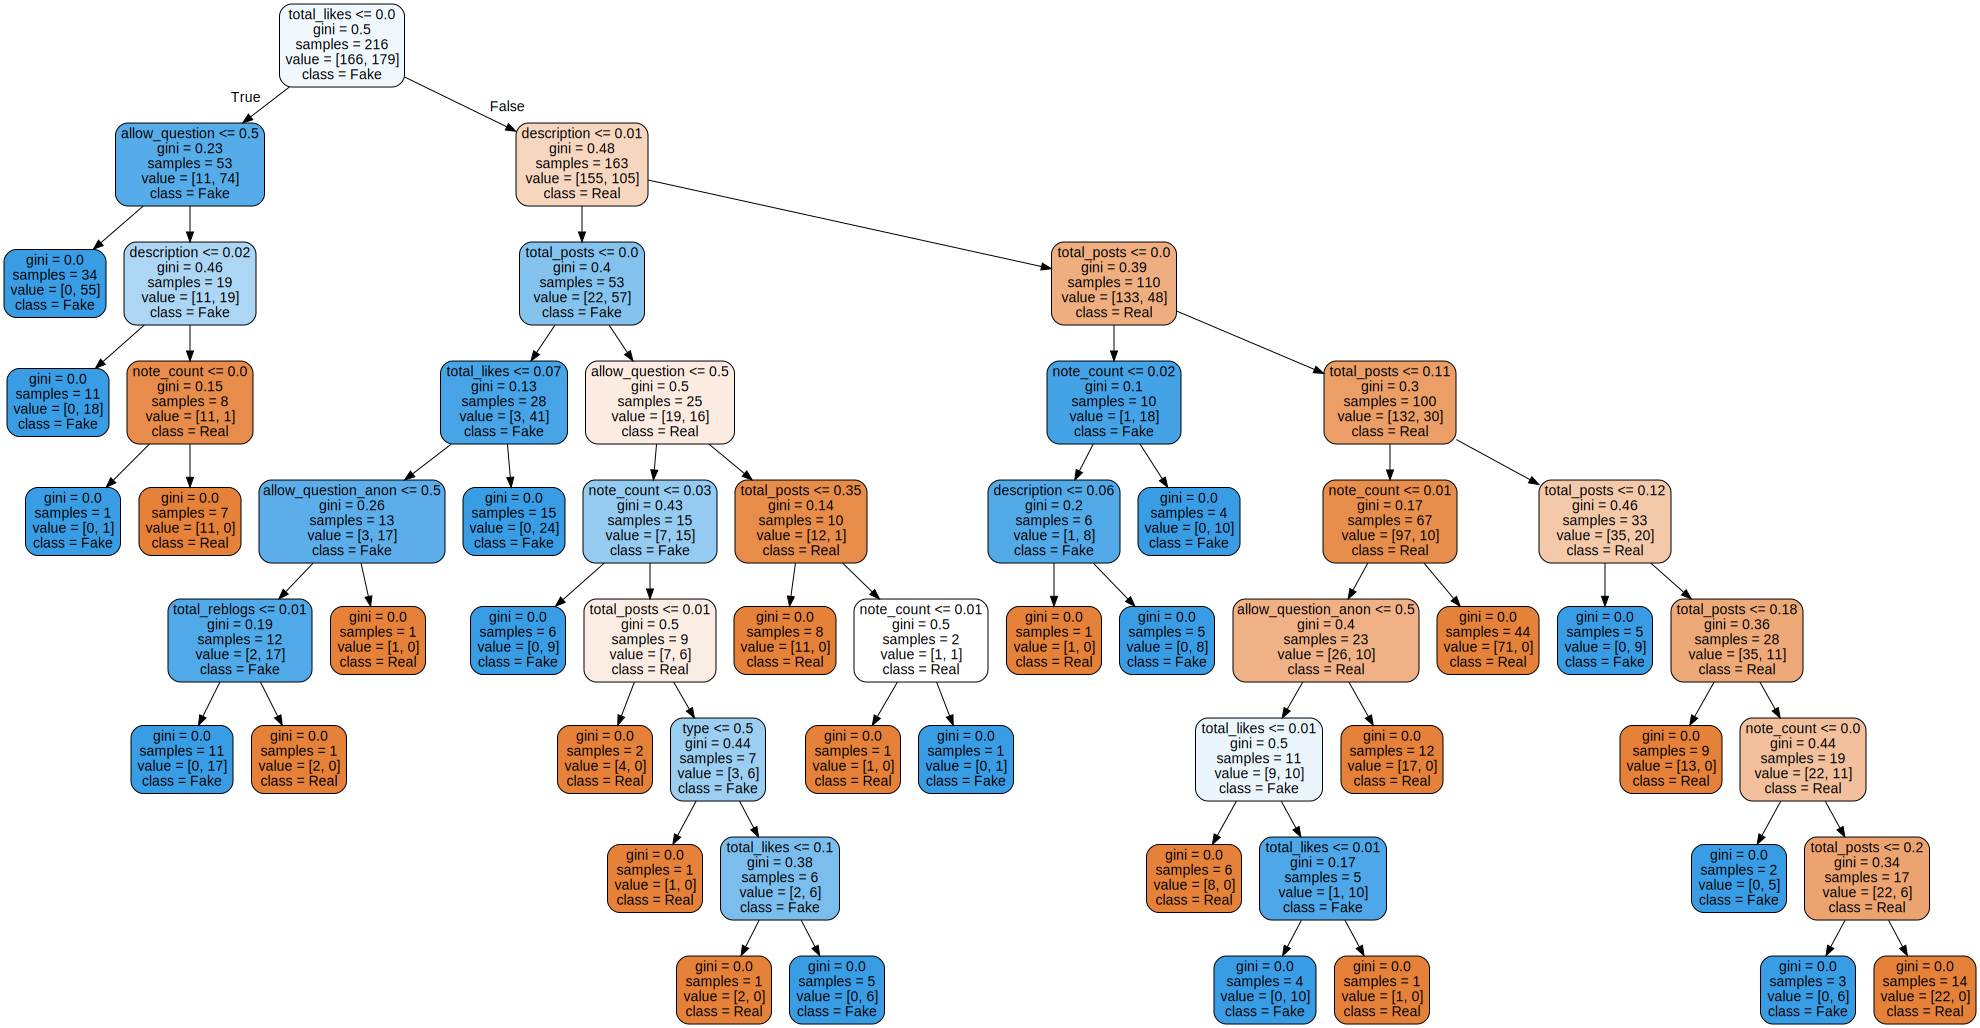

In [41]:
tree = rf.estimators_[0]

# Export this tree to a dot file
export_graphviz(tree, out_file='tree.dot',
                feature_names = final_data.drop('fake', axis=1).columns,
                class_names = ['Real', 'Fake'],
                rounded = True, proportion = False,
                precision = 2, filled = True)

# Use graphviz to read the dot file and plot the tree
with open('tree.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)